In [24]:
import pandas as pd
import numpy as np
import re
from arabic_reshaper import reshape
import pyarabic.araby as araby
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, Input, Conv1D, MaxPooling1D, Concatenate, LSTM, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('ar_reviews_100k.tsv', sep='\t')

In [3]:
# Print columns and check label distribution
print(df.columns)
print(df['label'].value_counts())


Index(['label', 'text'], dtype='object')
label
Positive    33333
Mixed       33333
Negative    33333
Name: count, dtype: int64


In [4]:
# Normalize and preprocess text
def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ئ", "ي", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    text = re.sub(r'\.+', '', text)
    return text

In [5]:
def preprocess_text(text):
    text = normalize_arabic(text)
    return text

def clean_text(text):
    text = re.sub(r'_', ' ', text)
    tokens = araby.tokenize(text)
    clean_tokens = [word for word in tokens if araby.is_arabicword(word) or isemoji(word)]
    return ' '.join(clean_tokens)

In [6]:
def isemoji(word):
    emoji_pattern = re.match("["
                             u"\U0001F600-\U0001F64F"  
                             u"\U0001F300-\U0001F5FF"  
                             u"\U0001F680-\U0001F6FF"  
                             u"\U0001F1E0-\U0001F1FF"  
                             u"\U00002500-\U00002BEF"  
                             u"\U00002702-\U000027B0"
                             u"\U00002702-\U000027B0"
                             u"\U000024C2-\U0001F251"
                             u"\U0001f926-\U0001f937"
                             u"\U00010000-\U0010ffff"
                             u"\u2640-\u2642"
                             u"\u2600-\u2B55"
                             u"\u200d"
                             u"\u23cf"
                             u"\u23e9"
                             u"\u231a"
                             u"\ufe0f"  
                             u"\u3030"
                             "]+", word)
    return bool(emoji_pattern)


In [7]:
df['text'] = df['text'].apply(preprocess_text)

df = df.rename(columns={'label': 'Sentiment', 'text': 'Tweet'})



In [8]:
# Filter to only have positive and negative tweets
df = df[df['Sentiment'].isin(['Positive', 'Negative'])]

In [9]:
print(df['Sentiment'].value_counts())

Sentiment
Positive    33333
Negative    33333
Name: count, dtype: int64


In [10]:
# Tokenization and padding
def windowed(text, n):
    for i in range(len(text) - n + 1):
        yield text[i:i+n]

In [11]:
max_len = max(len(tweet.split()) for tweet in df['Tweet'])

In [12]:
char_tokenizer = Tokenizer(char_level=True)
word_tokenizer = Tokenizer()
ch5gram_tokenizer = Tokenizer()

char_tokenizer.fit_on_texts(df['Tweet'])
word_tokenizer.fit_on_texts(df['Tweet'])

ch5gram_texts = [''.join(list(windowed(text, 5))) for text in df['Tweet']]
ch5gram_tokenizer.fit_on_texts(ch5gram_texts)

char_sequences = char_tokenizer.texts_to_sequences(df['Tweet'])
word_sequences = word_tokenizer.texts_to_sequences(df['Tweet'])
ch5gram_sequences = ch5gram_tokenizer.texts_to_sequences(ch5gram_texts)

char_X = pad_sequences(char_sequences, maxlen=max_len, padding='post')
word_X = pad_sequences(word_sequences, maxlen=max_len, padding='post')
ch5gram_X = pad_sequences(ch5gram_sequences, maxlen=max_len, padding='post')



In [13]:
y = to_categorical(df['Sentiment'].map({'Positive': 1, 'Negative': 0}))

# Split data into training and testing sets
char_X_train, char_X_test, word_X_train, word_X_test, ch5gram_X_train, ch5gram_X_test, y_train, y_test = train_test_split(
    char_X, word_X, ch5gram_X, y, test_size=0.2, random_state=42)


In [14]:
# Embedding dimensions and maximum tokens
embedding_dim = 100
max_chars = len(char_tokenizer.word_index) + 1
max_words = len(word_tokenizer.word_index) + 1
max_ch5grams = len(ch5gram_tokenizer.word_index) + 1

In [15]:
# Input layers
char_input = Input(shape=(max_len,), name='char_input')
word_input = Input(shape=(max_len,), name='word_input')
ch5gram_input = Input(shape=(max_len,), name='ch5gram_input')

In [16]:
# Embedding layers
char_embedding = Embedding(max_chars, embedding_dim)(char_input)
word_embedding = Embedding(max_words, embedding_dim)(word_input)
ch5gram_embedding = Embedding(max_ch5grams, embedding_dim)(ch5gram_input)


In [17]:
# Define convolutional and pooling layers
filter_sizes = [3, 4, 5]
num_filters = 100
dropout_rate = 0.5

In [18]:
def create_conv_layers(embedding):
    conv_layers = []
    for filter_size in filter_sizes:
        conv = Conv1D(filters=num_filters, kernel_size=filter_size, padding='valid', activation='relu', strides=1)(embedding)
        pool = MaxPooling1D(pool_size=max_len - filter_size + 1)(conv)
        conv_layers.append(pool)
    return conv_layers


In [19]:
char_conv_layers  = create_conv_layers(char_embedding)
word_conv_layers = create_conv_layers(word_embedding)
ch5gram_conv_layers = create_conv_layers(ch5gram_embedding)

# Concatenate convolutional layers
char_concat = Concatenate(axis=1)(char_conv_layers)
word_concat = Concatenate(axis=1)(word_conv_layers)
ch5gram_concat = Concatenate(axis=1)(ch5gram_conv_layers)

# Add LSTM layers
lstm_units = 128
char_lstm = LSTM(lstm_units)(char_concat)
word_lstm = LSTM(lstm_units)(word_concat)
ch5gram_lstm = LSTM(lstm_units)(ch5gram_concat)

In [20]:
# Concatenate all LSTM outputs
merged = Concatenate(axis=1)([char_lstm, word_lstm, ch5gram_lstm])

# Apply Dropout
dropout = Dropout(dropout_rate)(merged)

# Fully connected layer
dense = Dense(128, activation='relu')(dropout)

# Output layer with softmax activation for binary classification
output = Dense(2, activation='softmax')(dense)


In [21]:
# Create and compile the model
model = Model(inputs=[char_input, word_input, ch5gram_input], outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ char_input (InputLayer)       │ (None, 1612)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ word_input (InputLayer)       │ (None, 1612)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ ch5gram_input (InputLayer)    │ (None, 1612)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Embedding)         │ (None, 1612, 100)         │           3,900 │ char_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_1 (Embedding)       │ (None, 1612, 100)         │      24,479,700 │ word_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_2 (Embedding)       │ (None, 1612, 100)         │      28,073,600 │ ch5gram_input[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d (Conv1D)               │ (None, 1610, 100)         │          30,100 │ embedding[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_1 (Conv1D)             │ (None, 1609, 100)         │          40,100 │ embedding[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_2 (Conv1D)             │ (None, 1608, 100)         │          50,100 │ embedding[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_3 (Conv1D)             │ (None, 1610, 100)         │          30,100 │ embedding_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_4 (Conv1D)             │ (None, 1609, 100)         │          40,100 │ embedding_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_5 (Conv1D)             │ (None, 1608, 100)         │          50,100 │ embedding_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_6 (Conv1D)             │ (None, 1610, 100)         │          30,100 │ embedding_2[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_7 (Conv1D)             │ (None, 1609, 100)         │          40,100 │ embedding_2[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_8 (Conv1D)             │ (None, 1608, 100)         │          50,100 │ embedding_2[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d (MaxPooling1D)  │ (None, 1, 100)            │               0 │ conv1d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d_1               │ (None, 1, 100)            │               0 │ conv1d_1[0][0]             │
│ (MaxPooling1D)                │                           │               

 Total params: 53,319,382 (203.40 MB)

 Trainable params: 53,319,382 (203.40 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# Train the model
history = model.fit([char_X_train, word_X_train, ch5gram_X_train], y_train, batch_size=32, epochs=1, validation_split=0.2)


1334/1334 ━━━━━━━━━━━━━━━━━━━━ 1790s 1s/step - accuracy: 0.7557 - loss: 0.4476 - val_accuracy: 0.8625 - val_loss: 0.3131


In [28]:
# Get the indices of negative and positive tweets in the test set
neg_indices = np.where(np.argmax(y_test, axis=1) == 0)[0]
pos_indices = np.where(np.argmax(y_test, axis=1) == 1)[0]


In [34]:
# Get predictions for negative tweets for each sentiment analysis level separately
char_y_pred_neg = model.predict([char_X_test[neg_indices], word_X_test[neg_indices], ch5gram_X_test[neg_indices]])
word_y_pred_neg = model.predict([word_X_test[neg_indices], word_X_test[neg_indices], ch5gram_X_test[neg_indices]])
ch5gram_y_pred_neg = model.predict([ch5gram_X_test[neg_indices], word_X_test[neg_indices], ch5gram_X_test[neg_indices]])

# Get predictions for positive tweets for each sentiment analysis level separately
char_y_pred_pos = model.predict([char_X_test[pos_indices], word_X_test[pos_indices], ch5gram_X_test[pos_indices]])
word_y_pred_pos = model.predict([word_X_test[pos_indices], word_X_test[pos_indices], ch5gram_X_test[pos_indices]])
ch5gram_y_pred_pos = model.predict([ch5gram_X_test[pos_indices], word_X_test[pos_indices], ch5gram_X_test[pos_indices]])

# Get true labels for negative tweets at each sentiment analysis level
char_y_true_neg = np.argmax(y_test[neg_indices], axis=1)
word_y_true_neg = np.argmax(y_test[neg_indices], axis=1)
ch5gram_y_true_neg = np.argmax(y_test[neg_indices], axis=1)

# Get true labels for positive tweets at each sentiment analysis level
char_y_true_pos = np.argmax(y_test[pos_indices], axis=1)
word_y_true_pos = np.argmax(y_test[pos_indices], axis=1)
ch5gram_y_true_pos = np.argmax(y_test[pos_indices], axis=1)

# Calculate accuracy for negative tweets at each sentiment analysis level
char_accuracy_neg = accuracy_score(char_y_true_neg, np.argmax(char_y_pred_neg, axis=1))
word_accuracy_neg = accuracy_score(word_y_true_neg, np.argmax(word_y_pred_neg, axis=1))
ch5gram_accuracy_neg = accuracy_score(ch5gram_y_true_neg, np.argmax(ch5gram_y_pred_neg, axis=1))

# Calculate accuracy for positive tweets at each sentiment analysis level
char_accuracy_pos = accuracy_score(char_y_true_pos, np.argmax(char_y_pred_pos, axis=1))
word_accuracy_pos = accuracy_score(word_y_true_pos, np.argmax(word_y_pred_pos, axis=1))
ch5gram_accuracy_pos = accuracy_score(ch5gram_y_true_pos, np.argmax(ch5gram_y_pred_pos, axis=1))

# Print accuracy results
print("Accuracy for negative tweets:")
print("Character level accuracy:", char_accuracy_neg)
print("Word level accuracy:", word_accuracy_neg)
print("5-gram level accuracy:", ch5gram_accuracy_neg)

print("\nAccuracy for positive tweets:")
print("Character level accuracy:", char_accuracy_pos)
print("Word level accuracy:", word_accuracy_pos)
print("5-gram level accuracy:", ch5gram_accuracy_pos)

209/209 ━━━━━━━━━━━━━━━━━━━━ 53s 254ms/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 52s 250ms/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 53s 252ms/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 52s 249ms/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 53s 255ms/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 57s 273ms/step
Accuracy for negative tweets:
Character level accuracy: 0.9036992661374869
Word level accuracy: 0.9044481054365733
5-gram level accuracy: 0.903249962558035

Accuracy for positive tweets:
Character level accuracy: 0.8101246807871414
Word level accuracy: 0.8072705422863151
5-gram level accuracy: 0.8102748986029743


In [29]:
# Get predictions for negative tweets for each sentiment analysis level separately
char_y_pred_neg = model.predict([char_X_test[neg_indices], word_X_test[neg_indices], ch5gram_X_test[neg_indices]])
word_y_pred_neg = model.predict([word_X_test[neg_indices], word_X_test[neg_indices], ch5gram_X_test[neg_indices]])
ch5gram_y_pred_neg = model.predict([ch5gram_X_test[neg_indices], word_X_test[neg_indices], ch5gram_X_test[neg_indices]])

# Get predictions for positive tweets for each sentiment analysis level separately
char_y_pred_pos = model.predict([char_X_test[pos_indices], word_X_test[pos_indices], ch5gram_X_test[pos_indices]])
word_y_pred_pos = model.predict([word_X_test[pos_indices], word_X_test[pos_indices], ch5gram_X_test[pos_indices]])
ch5gram_y_pred_pos = model.predict([ch5gram_X_test[pos_indices], word_X_test[pos_indices], ch5gram_X_test[pos_indices]])



209/209 ━━━━━━━━━━━━━━━━━━━━ 54s 253ms/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 59s 283ms/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 54s 259ms/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 55s 263ms/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 53s 255ms/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 53s 251ms/step


In [23]:
# Evaluate the model for negative and positive tweets separately
neg_indices = [i for i in range(len(y_test)) if y_test[i][0] == 1]
pos_indices = [i for i in range(len(y_test)) if y_test[i][1] == 1]


In [24]:
loss_neg, accuracy_neg = model.evaluate([char_X_test[neg_indices], word_X_test[neg_indices], ch5gram_X_test[neg_indices]], y_test[neg_indices])
print(f'Test Set Accuracy for Negative Tweets: {accuracy_neg * 100:.2f}%')


209/209 ━━━━━━━━━━━━━━━━━━━━ 50s 239ms/step - accuracy: 0.8770 - loss: 0.2876
Test Set Accuracy for Negative Tweets: 87.81%


In [25]:
loss_pos, accuracy_pos = model.evaluate([char_X_test[pos_indices], word_X_test[pos_indices], ch5gram_X_test[pos_indices]], y_test[pos_indices])
print(f'Test Set Accuracy for Positive Tweets: {accuracy_pos * 100:.2f}%')


209/209 ━━━━━━━━━━━━━━━━━━━━ 55s 265ms/step - accuracy: 0.8659 - loss: 0.3146
Test Set Accuracy for Positive Tweets: 86.39%


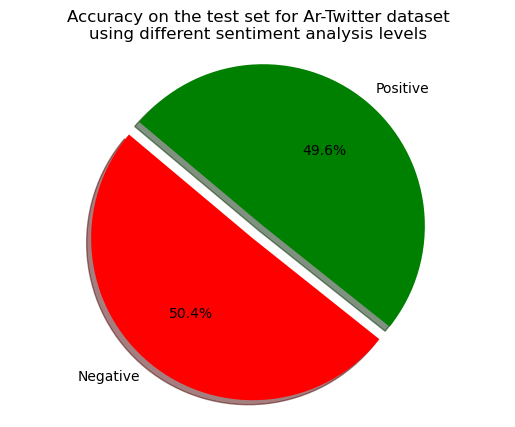

In [32]:
# Plot the results as a pie chart
labels = ['Negative', 'Positive']
accuracies = [accuracy_neg, accuracy_pos]
colors = ['red', 'green']
explode = (0.1, 0)  

fig, ax = plt.subplots()
ax.pie(accuracies, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
ax.axis('equal')  
ax.set_title('Accuracy on the test set for Ar-Twitter dataset')

plt.show()

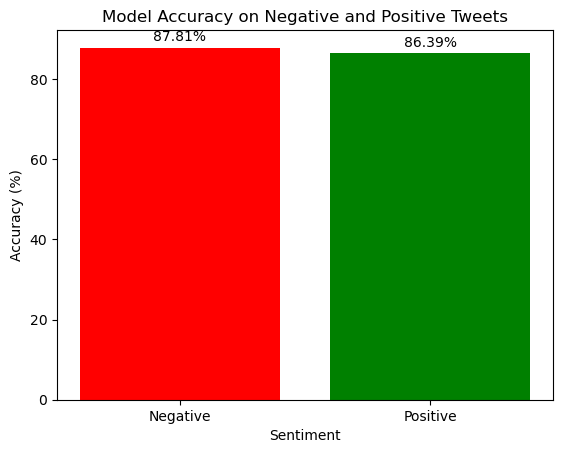

In [35]:
# Plot the model accuracy on negative and positive tweets
labels = ['Negative', 'Positive']
accuracies = [accuracy_neg * 100, accuracy_pos * 100]
colors = ['red', 'green']

plt.bar(labels, accuracies, color=colors)
plt.title('Model Accuracy on Negative and Positive Tweets')
plt.xlabel('Sentiment')
plt.ylabel('Accuracy (%)')

# Add accuracy values on top of bars
for i, v in enumerate(accuracies):
    plt.text(i, v + 1, f'{v:.2f}%', ha='center', va='bottom')

plt.show()


In [48]:
from sklearn.metrics import classification_report

# Get predictions for negative tweets for each sentiment analysis level separately
char_y_pred_neg = model.predict([char_X_test[neg_indices], word_X_test[neg_indices], ch5gram_X_test[neg_indices]])
word_y_pred_neg = model.predict([word_X_test[neg_indices], word_X_test[neg_indices], ch5gram_X_test[neg_indices]])
ch5gram_y_pred_neg = model.predict([ch5gram_X_test[neg_indices], word_X_test[neg_indices], ch5gram_X_test[neg_indices]])

# Get predictions for positive tweets for each sentiment analysis level separately
char_y_pred_pos = model.predict([char_X_test[pos_indices], word_X_test[pos_indices], ch5gram_X_test[pos_indices]])
word_y_pred_pos = model.predict([word_X_test[pos_indices], word_X_test[pos_indices], ch5gram_X_test[pos_indices]])
ch5gram_y_pred_pos = model.predict([ch5gram_X_test[pos_indices], word_X_test[pos_indices], ch5gram_X_test[pos_indices]])

# Convert predictions to labels
char_y_pred_labels_neg = np.argmax(char_y_pred_neg, axis=1)
word_y_pred_labels_neg = np.argmax(word_y_pred_neg, axis=1)
ch5gram_y_pred_labels_neg = np.argmax(ch5gram_y_pred_neg, axis=1)

char_y_pred_labels_pos = np.argmax(char_y_pred_pos, axis=1)
word_y_pred_labels_pos = np.argmax(word_y_pred_pos, axis=1)
ch5gram_y_pred_labels_pos = np.argmax(ch5gram_y_pred_pos, axis=1)

# Get true labels for negative and positive tweets
y_true_neg = np.argmax(y_test[neg_indices], axis=1)
y_true_pos = np.argmax(y_test[pos_indices], axis=1)

# Print classification report for negative and positive tweets for each sentiment analysis level
print("Classification Report for Negative Tweets - Char-level:")
print(classification_report(y_true_neg, char_y_pred_labels_neg, zero_division=1))

print("\nClassification Report for Negative Tweets - Word-level:")
print(classification_report(y_true_neg, word_y_pred_labels_neg, zero_division=1))

print("\nClassification Report for Negative Tweets - Ch5gram-level:")
print(classification_report(y_true_neg, ch5gram_y_pred_labels_neg, zero_division=1))

print("\nClassification Report for Positive Tweets - Char-level:")
print(classification_report(y_true_pos, char_y_pred_labels_pos, zero_division=1))

print("\nClassification Report for Positive Tweets - Word-level:")
print(classification_report(y_true_pos, word_y_pred_labels_pos, zero_division=1))

print("\nClassification Report for Positive Tweets - Ch5gram-level:")
print(classification_report(y_true_pos, ch5gram_y_pred_labels_pos, zero_division=1))


209/209 ━━━━━━━━━━━━━━━━━━━━ 102s 486ms/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 103s 493ms/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 102s 487ms/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 101s 481ms/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 103s 492ms/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 102s 489ms/step
Classification Report for Negative Tweets - Char-level:
              precision    recall  f1-score   support

           0       1.00      0.83      0.91      6677
           1       0.00      1.00      0.00         0

    accuracy                           0.83      6677
   macro avg       0.50      0.91      0.45      6677
weighted avg       1.00      0.83      0.91      6677


Classification Report for Negative Tweets - Word-level:
              precision    recall  f1-score   support

           0       1.00      0.83      0.90      6677
           1       0.00      1.00      0.00         0

    accuracy                           0.83      6677
   macro avg       0.50      0.91      0.45      6677
weighted avg      